In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_075_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_075_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1889 - acc: 0.2245
Epoch 00001: val_loss improved from inf to 2.23981, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_1_conv_checkpoint/001-2.2398.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 3.1886 - acc: 0.2245 - val_loss: 2.2398 - val_acc: 0.3189
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6612 - acc: 0.4896
Epoch 00002: val_loss did not improve from 2.23981
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.6612 - acc: 0.4896 - val_loss: 2.4571 - val_acc: 0.3119
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9501
Epoch 00027: val_loss did not improve from 2.23981
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1765 - acc: 0.9501 - val_loss: 5.7983 - val_acc: 0.2807
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9522
Epoch 00028: val_loss did not improve from 2.23981
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1688 - acc: 0.9522 - val_loss: 4.9282 - val_acc: 0.3017
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1665 - acc: 0.9541
Epoch 00029: val_loss did not improve from 2.23981
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1665 - acc: 0.9541 - val_loss: 5.5324 - val_acc: 0.2690
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1614 - acc: 0.9564
Epoch 00030: val_loss did not improve from 2.23981
36805/36805 [===========

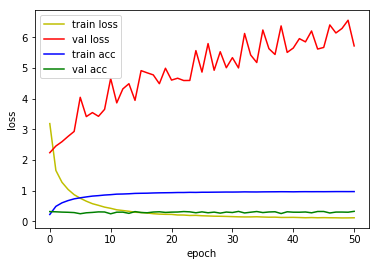

4815/4815 [==============================] - 2s 404us/sample - loss: 2.2795 - acc: 0.2860
Loss: 2.2795086906458852 Accuracy: 0.2859813

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3628 - acc: 0.2351
Epoch 00001: val_loss improved from inf to 3.07166, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_2_conv_checkpoint/001-3.0717.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.3630 - acc: 0.2351 - val_loss: 3.0717 - val_acc: 0.2576
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6683 - acc: 0.3631
Epoch 00002: val_loss improved from 3.07166 to 2.30448, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_2_conv_checkpoint/002-2.3045.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 2.6684 - acc: 0.3630 - val_loss: 2.3045 - val_acc: 0.3892
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3070 - acc: 0.9049
Epoch 00029: val_loss did not improve from 2.29805
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.3069 - acc: 0.9050 - val_loss: 3.2470 - val_acc: 0.4556
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2957 - acc: 0.9095
Epoch 00030: val_loss did not improve from 2.29805
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.2957 - acc: 0.9095 - val_loss: 3.1384 - val_acc: 0.4640
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2744 - acc: 0.9168
Epoch 00031: val_loss did not improve from 2.29805
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.2744 - acc: 0.9168 - val_loss: 3.3027 - val_acc: 0.4580
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2609 - acc: 0.9191
Epoch 00032: val_loss did not improve from 2.29805
36805/36805 [===========

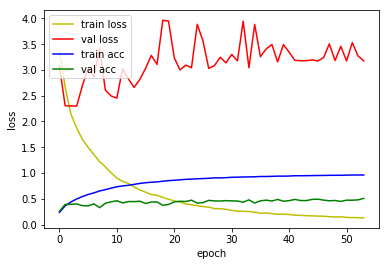

4815/4815 [==============================] - 3s 716us/sample - loss: 2.4671 - acc: 0.3776
Loss: 2.4670915194142027 Accuracy: 0.3775701

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7201 - acc: 0.2797
Epoch 00001: val_loss improved from inf to 2.01939, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_3_conv_checkpoint/001-2.0194.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.7200 - acc: 0.2797 - val_loss: 2.0194 - val_acc: 0.3382
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8943 - acc: 0.4526
Epoch 00002: val_loss improved from 2.01939 to 1.78835, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_3_conv_checkpoint/002-1.7884.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.8947 - acc: 0.4525 - val_loss: 1.7884 - val_acc: 0.5094
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.3651 - acc: 0.8794
Epoch 00028: val_loss did not improve from 1.23846
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3651 - acc: 0.8794 - val_loss: 1.3233 - val_acc: 0.6967
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3592 - acc: 0.8813
Epoch 00029: val_loss did not improve from 1.23846
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3591 - acc: 0.8813 - val_loss: 1.3052 - val_acc: 0.6928
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3564 - acc: 0.8834
Epoch 00030: val_loss did not improve from 1.23846
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3565 - acc: 0.8834 - val_loss: 1.6071 - val_acc: 0.6369
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3405 - acc: 0.8881
Epoch 00031: val_loss did not improve from 1.23846
36805/36805 [========================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1780 - acc: 0.9431
Epoch 00058: val_loss did not improve from 1.23846
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1782 - acc: 0.9431 - val_loss: 1.6897 - val_acc: 0.6478
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1851 - acc: 0.9417
Epoch 00059: val_loss did not improve from 1.23846
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1851 - acc: 0.9417 - val_loss: 1.4714 - val_acc: 0.6727

1D_CNN_custom_DO_075_DO_BN_3_conv Model


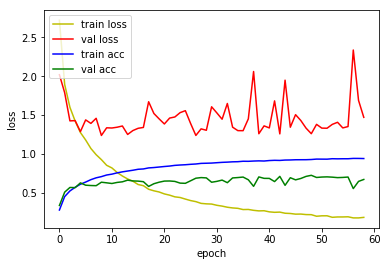

4815/4815 [==============================] - 4s 812us/sample - loss: 1.3749 - acc: 0.5931
Loss: 1.3749287855092858 Accuracy: 0.59314644

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8300 - acc: 0.2625
Epoch 00001: val_loss improved from inf to 1.68567, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_4_conv_checkpoint/001-1.6857.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.8302 - acc: 0.2625 - val_loss: 1.6857 - val_acc: 0.4456
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8659 - acc: 0.4444
Epoch 00002: val_loss improved from 1.68567 to 1.24365, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_4_conv_checkpoint/002-1.2436.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.8657 - acc: 0.4445 - val_loss: 1.2436 - val_acc: 0.6287
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5240 - acc: 0.8340
Epoch 00026: val_loss did not improve from 0.73444
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5241 - acc: 0.8340 - val_loss: 0.7520 - val_acc: 0.7887
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5111 - acc: 0.8376
Epoch 00027: val_loss did not improve from 0.73444
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5116 - acc: 0.8375 - val_loss: 0.7459 - val_acc: 0.7864
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5006 - acc: 0.8405
Epoch 00028: val_loss did not improve from 0.73444
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5006 - acc: 0.8405 - val_loss: 0.8061 - val_acc: 0.7761
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4860 - acc: 0.8466
Epoch 00029: val_loss did not improve from 0.73444
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2942 - acc: 0.9030
Epoch 00055: val_loss did not improve from 0.69356
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2943 - acc: 0.9030 - val_loss: 0.7042 - val_acc: 0.8141
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2952 - acc: 0.9041
Epoch 00056: val_loss did not improve from 0.69356
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2951 - acc: 0.9041 - val_loss: 0.7273 - val_acc: 0.8074
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2886 - acc: 0.9053
Epoch 00057: val_loss did not improve from 0.69356
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2886 - acc: 0.9053 - val_loss: 0.7534 - val_acc: 0.8029
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2916 - acc: 0.9035
Epoch 00058: val_loss did not improve from 0.69356
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9323
Epoch 00085: val_loss did not improve from 0.68783
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2067 - acc: 0.9322 - val_loss: 0.7949 - val_acc: 0.8097
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9337
Epoch 00086: val_loss did not improve from 0.68783
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2061 - acc: 0.9337 - val_loss: 0.6945 - val_acc: 0.8265
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9310
Epoch 00087: val_loss did not improve from 0.68783
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2075 - acc: 0.9310 - val_loss: 0.7476 - val_acc: 0.8213
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2033 - acc: 0.9354
Epoch 00088: val_loss did not improve from 0.68783
36805/36805 [===========

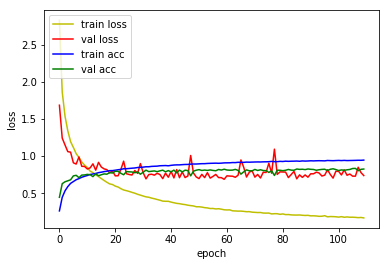

4815/4815 [==============================] - 4s 875us/sample - loss: 0.8049 - acc: 0.7769
Loss: 0.804949192441265 Accuracy: 0.776947

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8651 - acc: 0.2566
Epoch 00001: val_loss improved from inf to 1.74870, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_5_conv_checkpoint/001-1.7487.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.8652 - acc: 0.2566 - val_loss: 1.7487 - val_acc: 0.4065
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7746 - acc: 0.4686
Epoch 00002: val_loss improved from 1.74870 to 1.17821, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_5_conv_checkpoint/002-1.1782.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.7746 - acc: 0.4686 - val_loss: 1.1782 - val_acc: 0.6296
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4943 - acc: 0.8485
Epoch 00025: val_loss improved from 0.58081 to 0.54793, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_5_conv_checkpoint/025-0.5479.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4943 - acc: 0.8485 - val_loss: 0.5479 - val_acc: 0.8400
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4786 - acc: 0.8533
Epoch 00026: val_loss did not improve from 0.54793
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4788 - acc: 0.8533 - val_loss: 0.5971 - val_acc: 0.8286
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4788 - acc: 0.8498
Epoch 00027: val_loss did not improve from 0.54793
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4789 - acc: 0.8498 - val_loss: 0.6187 - val_acc: 0.8202
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2886 - acc: 0.9062
Epoch 00053: val_loss did not improve from 0.50333
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2885 - acc: 0.9063 - val_loss: 0.5699 - val_acc: 0.8523
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2816 - acc: 0.9083
Epoch 00054: val_loss did not improve from 0.50333
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2816 - acc: 0.9084 - val_loss: 0.5382 - val_acc: 0.8556
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2754 - acc: 0.9119
Epoch 00055: val_loss did not improve from 0.50333
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2754 - acc: 0.9119 - val_loss: 0.5212 - val_acc: 0.8556
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2735 - acc: 0.9117
Epoch 00056: val_loss did not improve from 0.50333
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1963 - acc: 0.9362
Epoch 00082: val_loss did not improve from 0.48975
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1963 - acc: 0.9363 - val_loss: 0.5798 - val_acc: 0.8521
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1953 - acc: 0.9377
Epoch 00083: val_loss did not improve from 0.48975
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1953 - acc: 0.9378 - val_loss: 0.5381 - val_acc: 0.8698
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1808 - acc: 0.9420
Epoch 00084: val_loss did not improve from 0.48975
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1811 - acc: 0.9420 - val_loss: 0.5286 - val_acc: 0.8663
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1911 - acc: 0.9392
Epoch 00085: val_loss did not improve from 0.48975
36805/36805 [========================

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1408 - acc: 0.9534
Epoch 00112: val_loss did not improve from 0.48975
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1408 - acc: 0.9534 - val_loss: 0.5612 - val_acc: 0.8691
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9546
Epoch 00113: val_loss did not improve from 0.48975
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1400 - acc: 0.9546 - val_loss: 0.5819 - val_acc: 0.8586
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1388 - acc: 0.9557
Epoch 00114: val_loss did not improve from 0.48975
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1388 - acc: 0.9557 - val_loss: 0.5271 - val_acc: 0.8789
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1403 - acc: 0.9557
Epoch 00115: val_loss did not improve from 0.48975
36805/36805 [=======

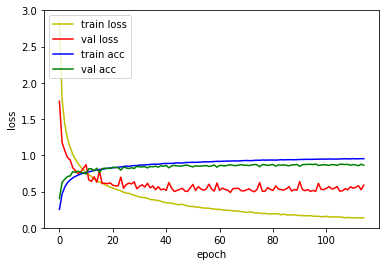

4815/4815 [==============================] - 4s 914us/sample - loss: 0.5975 - acc: 0.8397
Loss: 0.597500038320278 Accuracy: 0.8396677

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9785 - acc: 0.2126
Epoch 00001: val_loss improved from inf to 1.91298, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/001-1.9130.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 2.9785 - acc: 0.2127 - val_loss: 1.9130 - val_acc: 0.3457
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8788 - acc: 0.4240
Epoch 00002: val_loss improved from 1.91298 to 1.22668, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/002-1.2267.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.8787 - acc: 0.4240 - val_loss: 1.2267 - val_acc: 0.6280
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.4101 - acc: 0.8761
Epoch 00025: val_loss improved from 0.41230 to 0.40969, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/025-0.4097.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4103 - acc: 0.8760 - val_loss: 0.4097 - val_acc: 0.8910
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3964 - acc: 0.8786
Epoch 00026: val_loss improved from 0.40969 to 0.40722, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/026-0.4072.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3964 - acc: 0.8786 - val_loss: 0.4072 - val_acc: 0.8921
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3883 - acc: 0.8796
Epoch 00027: val_loss did not improve from 0.40722
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3882 - acc: 0.8797 - val_loss: 0.4165 - val

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2396 - acc: 0.9246
Epoch 00053: val_loss did not improve from 0.32730
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2396 - acc: 0.9246 - val_loss: 0.3447 - val_acc: 0.9092
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2275 - acc: 0.9267
Epoch 00054: val_loss did not improve from 0.32730
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2278 - acc: 0.9266 - val_loss: 0.3375 - val_acc: 0.9073
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9259
Epoch 00055: val_loss did not improve from 0.32730
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2320 - acc: 0.9259 - val_loss: 0.3571 - val_acc: 0.9096
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2178 - acc: 0.9297
Epoch 00056: val_loss improved from 0.32730 to 0.32379, saving model to mod

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9487
Epoch 00082: val_loss did not improve from 0.30787
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1556 - acc: 0.9486 - val_loss: 0.4273 - val_acc: 0.8989
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1575 - acc: 0.9483
Epoch 00083: val_loss did not improve from 0.30787
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1575 - acc: 0.9483 - val_loss: 0.3456 - val_acc: 0.9122
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1522 - acc: 0.9497
Epoch 00084: val_loss did not improve from 0.30787
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1521 - acc: 0.9497 - val_loss: 0.3244 - val_acc: 0.9208
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1488 - acc: 0.9513
Epoch 00085: val_loss did not improve from 0.30787
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9619
Epoch 00111: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1163 - acc: 0.9619 - val_loss: 0.3820 - val_acc: 0.9133
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9637
Epoch 00112: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1085 - acc: 0.9637 - val_loss: 0.3541 - val_acc: 0.9175
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9632
Epoch 00113: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1137 - acc: 0.9632 - val_loss: 0.3237 - val_acc: 0.9287
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9633
Epoch 00114: val_loss did not improve from 0.30445
36805/36805 [=====================

Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9711
Epoch 00141: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0867 - acc: 0.9711 - val_loss: 0.3500 - val_acc: 0.9231
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9723
Epoch 00142: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0852 - acc: 0.9723 - val_loss: 0.3685 - val_acc: 0.9222
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0939 - acc: 0.9689
Epoch 00143: val_loss did not improve from 0.30445
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0939 - acc: 0.9689 - val_loss: 0.3456 - val_acc: 0.9257
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0825 - acc: 0.9729
Epoch 00144: val_loss did not improve from 0.30445
36805/36805 [=======

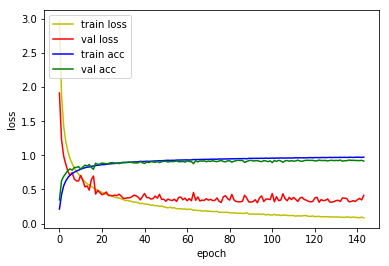

4815/4815 [==============================] - 5s 956us/sample - loss: 0.3791 - acc: 0.9024
Loss: 0.37910410796494254 Accuracy: 0.9023884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0999 - acc: 0.1834
Epoch 00001: val_loss improved from inf to 1.92708, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/001-1.9271.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 3.0998 - acc: 0.1834 - val_loss: 1.9271 - val_acc: 0.3972
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9570 - acc: 0.3914
Epoch 00002: val_loss improved from 1.92708 to 1.21084, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/002-1.2108.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.9569 - acc: 0.3914 - val_loss: 1.2108 - val_acc: 0.6378
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2872 - acc: 0.9103
Epoch 00025: val_loss improved from 0.24775 to 0.23752, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/025-0.2375.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2872 - acc: 0.9103 - val_loss: 0.2375 - val_acc: 0.9359
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2781 - acc: 0.9121
Epoch 00026: val_loss did not improve from 0.23752
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2781 - acc: 0.9121 - val_loss: 0.3300 - val_acc: 0.9203
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2719 - acc: 0.9157
Epoch 00027: val_loss improved from 0.23752 to 0.23405, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/027-0.2340.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2720 - acc: 0.9157 - val_loss: 0.2340 - val

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1414 - acc: 0.9557
Epoch 00053: val_loss did not improve from 0.20396
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1414 - acc: 0.9556 - val_loss: 0.2444 - val_acc: 0.9401
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9540
Epoch 00054: val_loss did not improve from 0.20396
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1436 - acc: 0.9541 - val_loss: 0.2623 - val_acc: 0.9345
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9556
Epoch 00055: val_loss did not improve from 0.20396
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1382 - acc: 0.9556 - val_loss: 0.2210 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1325 - acc: 0.9573
Epoch 00056: val_loss did not improve from 0.20396
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9721
Epoch 00082: val_loss did not improve from 0.19930
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0848 - acc: 0.9721 - val_loss: 0.2428 - val_acc: 0.9387
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9732
Epoch 00083: val_loss did not improve from 0.19930
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0854 - acc: 0.9732 - val_loss: 0.2262 - val_acc: 0.9488
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9712
Epoch 00084: val_loss did not improve from 0.19930
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0859 - acc: 0.9712 - val_loss: 0.2793 - val_acc: 0.9348
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9730
Epoch 00085: val_loss did not improve from 0.19930
36805/36805 [========================

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9787
Epoch 00112: val_loss did not improve from 0.19930
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0654 - acc: 0.9787 - val_loss: 0.2379 - val_acc: 0.9464
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9818
Epoch 00113: val_loss did not improve from 0.19930
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0554 - acc: 0.9818 - val_loss: 0.2702 - val_acc: 0.9432
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9813
Epoch 00114: val_loss did not improve from 0.19930
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0568 - acc: 0.9813 - val_loss: 0.2991 - val_acc: 0.9413
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9829
Epoch 00115: val_loss did not improve from 0.19930
36805/36805 [=======

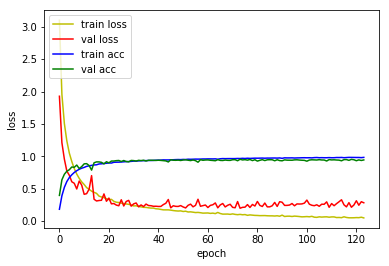

4815/4815 [==============================] - 5s 973us/sample - loss: 0.2264 - acc: 0.9375
Loss: 0.2263956613107541 Accuracy: 0.937487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1223 - acc: 0.1817
Epoch 00001: val_loss improved from inf to 2.00249, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/001-2.0025.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 3.1226 - acc: 0.1817 - val_loss: 2.0025 - val_acc: 0.4067
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0484 - acc: 0.3659
Epoch 00002: val_loss improved from 2.00249 to 1.20355, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/002-1.2036.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.0484 - acc: 0.3659 - val_loss: 1.2036 - val_acc: 0.6534
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.2085 - acc: 0.9331
Epoch 00024: val_loss improved from 0.17598 to 0.16472, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/024-0.1647.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.2087 - acc: 0.9331 - val_loss: 0.1647 - val_acc: 0.9513
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2025 - acc: 0.9368
Epoch 00025: val_loss did not improve from 0.16472
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.2026 - acc: 0.9368 - val_loss: 0.2072 - val_acc: 0.9406
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1839 - acc: 0.9431
Epoch 00026: val_loss did not improve from 0.16472
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1842 - acc: 0.9430 - val_loss: 0.1964 - val_acc: 0.9462
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1822 - a

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9734
Epoch 00051: val_loss did not improve from 0.13159
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0834 - acc: 0.9734 - val_loss: 0.1521 - val_acc: 0.9571
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9743
Epoch 00052: val_loss did not improve from 0.13159
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0792 - acc: 0.9743 - val_loss: 0.1508 - val_acc: 0.9595
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9743
Epoch 00053: val_loss did not improve from 0.13159
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0810 - acc: 0.9743 - val_loss: 0.1525 - val_acc: 0.9562
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0796 - acc: 0.9750
Epoch 00054: val_loss improved from 0.13159 to 0.12584, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9856
Epoch 00080: val_loss did not improve from 0.12584
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0456 - acc: 0.9856 - val_loss: 0.2294 - val_acc: 0.9499
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9817
Epoch 00081: val_loss did not improve from 0.12584
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0571 - acc: 0.9817 - val_loss: 0.1567 - val_acc: 0.9632
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9876
Epoch 00082: val_loss did not improve from 0.12584
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0386 - acc: 0.9876 - val_loss: 0.1788 - val_acc: 0.9604
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9878
Epoch 00083: val_loss did not improve from 0.12584
36805/36805 [========================

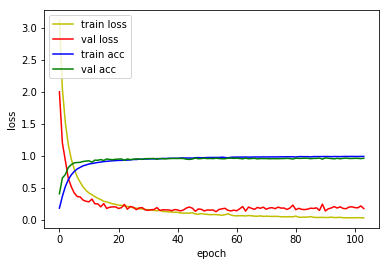

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1616 - acc: 0.9529
Loss: 0.16164906880318314 Accuracy: 0.95285565

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7998 - acc: 0.2876
Epoch 00001: val_loss improved from inf to 1.56511, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/001-1.5651.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 2.7998 - acc: 0.2876 - val_loss: 1.5651 - val_acc: 0.5090
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4840 - acc: 0.5570
Epoch 00002: val_loss improved from 1.56511 to 0.65389, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/002-0.6539.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.4840 - acc: 0.5570 - val_loss: 0.6539 - val_acc: 0.8116
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0943 - acc: 0.9705
Epoch 00025: val_loss improved from 0.12172 to 0.11093, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/025-0.1109.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0943 - acc: 0.9705 - val_loss: 0.1109 - val_acc: 0.9665
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9705
Epoch 00026: val_loss did not improve from 0.11093
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0921 - acc: 0.9705 - val_loss: 0.1135 - val_acc: 0.9674
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9724
Epoch 00027: val_loss did not improve from 0.11093
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0887 - acc: 0.9724 - val_loss: 0.1349 - val_acc: 0.9627
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9870
Epoch 00054: val_loss did not improve from 0.10473
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0409 - acc: 0.9870 - val_loss: 0.1099 - val_acc: 0.9720
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.10473
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0268 - acc: 0.9918 - val_loss: 0.1264 - val_acc: 0.9676
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9911
Epoch 00056: val_loss did not improve from 0.10473
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0282 - acc: 0.9911 - val_loss: 0.1246 - val_acc: 0.9665
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9909
Epoch 00057: val_loss did not improve from 0.10473
36805/36805 [===========

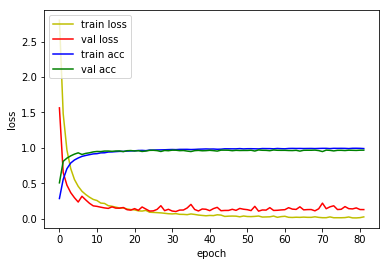

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1518 - acc: 0.9553
Loss: 0.15181389430176123 Accuracy: 0.9553479



In [9]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_075_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_075_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8049 - acc: 0.7769
Loss: 0.804949192441265 Accuracy: 0.776947

1D_CNN_custom_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2264 - acc: 0.9375
Loss: 0.2263956613107541 Accuracy: 0.937487

1D_CNN_custom_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1518 - acc: 0.9553
Loss: 0.15181389430176123 Accuracy: 0.9553479


In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.8305 - acc: 0.7934
Loss: 0.8305449603997782 Accuracy: 0.7933541

1D_CNN_custom_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3077 - acc: 0.9321
Loss: 0.30774628279202637 Accuracy: 0.93208724

1D_CNN_custom_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (No

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1780 - acc: 0.9585
Loss: 0.17802275132005357 Accuracy: 0.95846313
